# Introduction

The analysis contains several sections:
- Data Preperation
- Descriptive statistics and graphs regarding the whole data
- Modeling installation of HaMagen using logistic regression 
- Analyzing demographics of installing Hamagen
- Modeling approval with cellular contact tracing using OLS
- Modeling recommending HaMagen using OLS
- Modeling uninstallation of Hamagen using logistic regression

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import researchpy as rp
from sklearn.datasets import load_iris
from factor_analyzer import FactorAnalyzer
from statsmodels.formula.api import ols
import seaborn as sns
import scipy.stats as stats




# Data Preperation

Downloading the survey (sur) file from the OSF repository


In [67]:
sur = pd.read_csv('https://osf.io/zd8qk/download', index_col='Response ID')

sur.head()

#Creating factors
#sur['hamagen_limited_utility'] = (sur.hamagen_help_no_infect + sur.hamagen_reduce_my_risk) / 2
#sur['hamagen_recommend'] = (sur.hamagen_recommend + sur.hamagen_public_areas) / 2
#sur['covid_concern'] = (sur.corona_threat_population + sur.corona_threat_population + sur.corona_worry_me + sur.corona_worry_others) / 4
#sur['hamagen_privacy'] = (sur.hamagen_privacy_concern + sur.hamagen_can_collect_sensitive) / 2
#sur['cellular_utility'] = (sur.cellular_help_prevent + sur.cellular_reduce_my_risk) / 2
#sur['cellular_privacy'] = (sur.cellular_privacy_concern + sur.cellular_can_collect) / 2
#sur['hamagen_limited_utility'] = (sur.hamagen_help_no_infect + sur.hamagen_reduce_my_risk) / 2
#sur['tech'] = (sur['know_pdf'] + sur['know_wiki'] + sur['know_cache'] + sur['know_phishing'] + sur['know_spyware'])/5

,Time Started,Date Submitted,Status,age,corona_threat_population,corona_threat_me,corona_worry_me,corona_worry_others,trust_leaders,follow_instructions,was_in_quarentine,corona_financial_hurt,corona_positive,corona_know_positive,corona_family_risk,special_risk,work_in_healthcare,hamagen_install,hamagen_recommend,hamagen_help_no_infect,hamagen_reduce_my_risk,hamagen_privacy_concern,hamagen_can_collect_sensitive,hamagen_wrong_location,hamagen_errors,hamagen_battery,hamagen_public_areas,cellular_trust_delete,cellular_accept_leave_phone_home,cellular_help_prevent,cellular_reduce_my_risk,cellular_privacy_concern,cellular_can_collect,solve_computer_problems,know_pdf,know_spyware,know_wiki,know_cache,know_phishing,gender,education,socio_economy,religion,religion_degree,language,hamagen_install_numbers,installed,gender_ord,socio_economy_level,education_level,religion_level,age_group,hamagen_can_collect,tech,language_level,religion_degree_level,gender_n,gender_cat,education_cat,age_group_n,religion_cat,cellular_trust,hamagen_privacy,cellular_utility,cellular_privacy,hamagen_limited_utility,cellular_attitude,hamagen_attitude,covid_concern,compliance,covid_trust
Response ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
379,05/05/2020 16:23,05/05/2020 16:26,Complete,21.0,3,2,4,4,3,5,No,4,No,No,Yes,No,No,No,2,3,2,4,3,NaN,NaN,NaN,2,3,4,3,2,4,3,5,5,4,5,5,5,male,Highschool,Below Average,Jewish,Secular,hebrew,0,0,1,1,2,1,2,3,4.8,1,1.0,1,1,2,2,1,-1,3.5,2.5,3.5,2.5,2.666667,2.0,3.000000,3.25,4.0
61,04/05/2020 19:23,04/05/2020 19:29,Complete,34.0,4,3,5,5,4,5,No,2,No,No,Yes,No,No,No,2,4,5,4,4,NaN,NaN,NaN,4,3,4,4,4,4,4,3,3,1,1,1,1,male,Highschool,Strongly Below Average,Muslim,Other,arabic,0,0,1,0,2,2,3,4,1.4,2,0.0,1,1,2,3,2,-1,4.0,4.0,4.0,4.5,3.666667,3.0,4.000000,4.25,4.5
280,05/05/2020 15:22,05/05/2020 15:24,Complete,21.0,2,3,4,2,3,3,No,3,No,No,No,No,No,Yes,3,3,3,3,3,3.0,3.0,3.0,3,3,3,3,3,3,3,3,3,3,3,3,3,male,Bachelor,Below Average,Druze,Other,arabic,1,1,1,1,4,3,2,3,3.0,2,0.0,1,1,4,2,3,0,3.0,3.0,3.0,3.0,3.000000,3.0,3.000000,2.75,3.0
288,05/05/2020 15:24,05/05/2020 15:33,Complete,65.0,2,3,1,1,4,5,No,3,No,No,No,No,No,No,2,4,4,3,4,NaN,NaN,NaN,1,3,3,4,4,1,4,3,4,1,1,3,1,female,Highschool,Average,Jewish,Traditional,hebrew,0,0,0,3,2,1,6,4,2.0,1,2.0,0,0,2,6,1,2,3.5,4.0,2.5,4.0,3.666667,1.5,2.000000,1.75,4.5
96,04/05/2020 23:27,04/05/2020 23:30,Complete,37.0,2,2,3,4,2,3,No,3,No,No,Yes,No,No,No,1,3,2,5,5,NaN,NaN,NaN,2,1,4,3,3,5,5,3,4,3,2,1,4,male,Bachelor,Average,Muslim,Other,arabic,0,0,1,3,4,2,3,5,2.8,2,0.0,1,1,4,3,2,-4,5.0,3.0,5.0,2.5,2.333333,1.5,2.333333,2.75,2.5


# Descriptive statistics

## Aux Functions

In [4]:
def create_stacked_bar(df, right_margin=1.3, hide_first_label=True, figsize=(16,10), savefile=False):
    likert_colors = ['white', '#e36c33', '#edad88','gainsboro','#829cb2','#3e6487']
    dummy = df.copy()
    column_names = df.columns
    middles = dummy[[column_names[0],column_names[1]]].sum(axis=1)+dummy[column_names[2]]*.5

    longest = middles.max()
    complete_longest = dummy.sum(axis=1).max()
    dummy.insert(0, '', (middles - longest).abs())

    ax = dummy.plot.barh(stacked=True, color=likert_colors, edgecolor='none', figsize=figsize)
    z = plt.axvline(longest, linestyle='--', color='#c7cdd1', alpha=1)
    z.set_zorder(-1)

    plt.margins(0.05, 0.1)
    plt.xlim(-10, int(complete_longest*right_margin))
    xvalues = range(0,int(complete_longest*right_margin),50)
    xlabels = [str(x-longest) for x in xvalues]
    plt.xticks(xvalues, xlabels)
    
    for lbl in ax.patches:
        if hide_first_label and lbl.get_x() > 0:
            ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')

    if savefile == True:
        plt.gcf().tight_layout()
        plt.savefig('output.png', format='png', orientation='landscape')
        
    plt.show()
    
    


## General Variables

- Almost perfect symmatry between people who believe that the corona 
- People are more worried about threat to others than to themselves (differnt for different ages?)
- About 65% either agree or strongly agree that they trust their leaders
- About 80% follow instructions

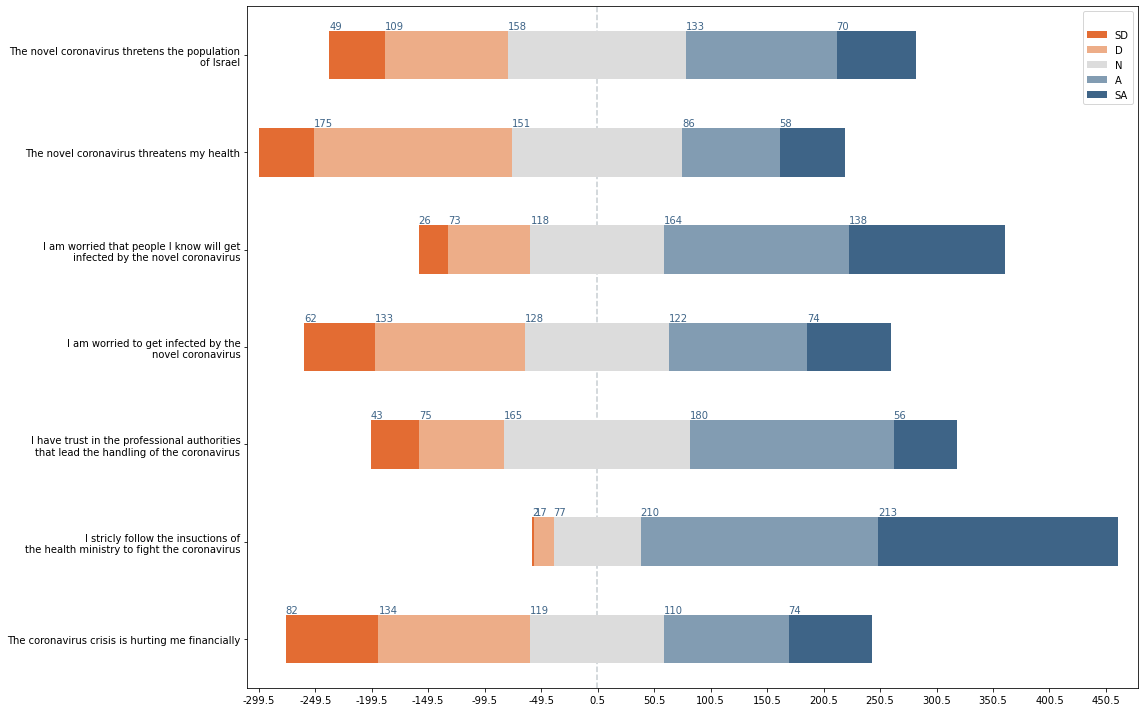

In [5]:
cols=['corona_financial_hurt', 'follow_instructions', 'trust_leaders', 'corona_worry_me', 'corona_worry_others', 
      'corona_threat_me', 'corona_threat_population'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1.head()
pivot_df = df1.transpose() 
pivot_df.columns = ['SD','D','N',
                     'A','SA']

pivot_df.rename(index={'corona_threat_population':'The novel coronavirus thretens the population\nof Israel'},inplace=True)
pivot_df.rename(index={'corona_threat_me':'The novel coronavirus threatens my health'},inplace=True)
pivot_df.rename(index={'corona_worry_others':'I am worried that people I know will get\ninfected by the novel coronavirus'},inplace=True)
pivot_df.rename(index={'corona_worry_me':'I am worried to get infected by the\nnovel coronavirus'},inplace=True)
pivot_df.rename(index={'trust_leaders':'I have trust in the professional authorities\nthat lead the handling of the coronavirus'},inplace=True)
pivot_df.rename(index={'follow_instructions':'I stricly follow the insuctions of\nthe health ministry to fight the coronavirus'},inplace=True)
pivot_df.rename(index={'corona_financial_hurt':'The coronavirus crisis is hurting me financially'},inplace=True)


create_stacked_bar(pivot_df, 1.5, savefile=True)

## Hamagen

We have asked our 520 participants about their views about The HaMagen app (The Shield) -- the official Israeli contact tracing app, developed by the Ministry of Health, and available for Android and iOS. These are some descriptive findings. 

About 31% of our participants have reported installing the app. This is higher than the official numbers of 1.58 million people who installed it in Israel (about 20% of the install base). However, our population is somewhat more educated than the average citizen -- and our results show a correlation between installation and education. 

People are not very happy with HaMagen. Only 28% will tend to recommend installing it to their friends and family (versus 43%). 27% think it will reduce their own chances of contracting the coronavirus and only 32% think it will reduce the spread of the virus in general (though only 28% have negative views).

Privacy concerns are prevelant. 59% feel that it collecs sensitive information (versus 19%) and 43% are worried for their privacy (versus 32% who do not have concerns). Further analysis shows that privacy concerns have a strong effect on installing the app and uninstalling it. 

          No  Yes  Removed
Install  308  166       45


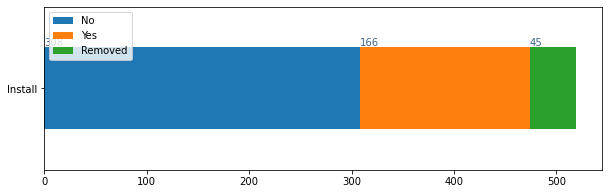

In [6]:
cols=['hamagen_install'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
pivot_df = df1.transpose() 

pivot_df.rename(index={'hamagen_install':'Install'},inplace=True)

print(pivot_df)

ax = pivot_df.plot.barh(stacked=True, figsize=(10,3))

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), horizontalalignment='left', verticalalignment='bottom', fontfamily='sans-serif', fontsize=10, color='#3e6487')


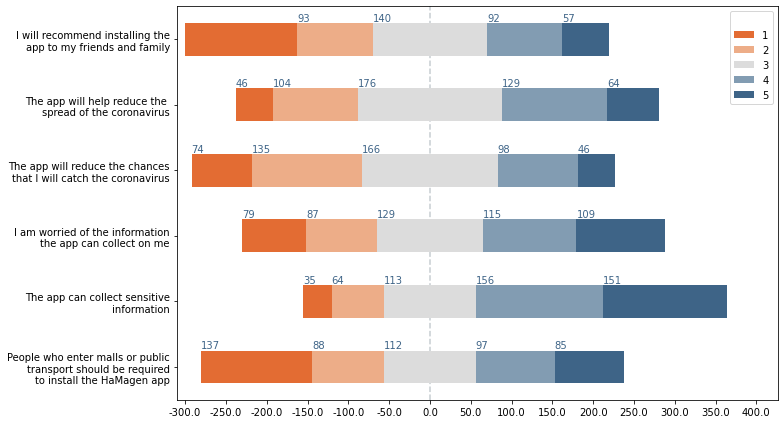

,1,2,3,4,5
People who enter malls or public\ntransport should be required\nto install the HaMagen app,137,88,112,97,85
The app can collect sensitive\ninformation,35,64,113,156,151
I am worried of the information\nthe app can collect on me,79,87,129,115,109
The app will reduce the chances\nthat I will catch the coronavirus,74,135,166,98,46
The app will help reduce the \nspread of the coronavirus,46,104,176,129,64
I will recommend installing the\napp to my friends and family,137,93,140,92,57


In [7]:
cols=['hamagen_public_areas', 'hamagen_can_collect_sensitive', 'hamagen_privacy_concern', 'hamagen_reduce_my_risk', 'hamagen_help_no_infect',
      'hamagen_recommend'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1.head()
likert_colors = ['firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
pivot_df = df1.transpose() 

pivot_df.rename(index={'hamagen_recommend':'I will recommend installing the\napp to my friends and family'},inplace=True)
pivot_df.rename(index={'hamagen_help_no_infect':'The app will help reduce the \nspread of the coronavirus'},inplace=True)
pivot_df.rename(index={'hamagen_reduce_my_risk':'The app will reduce the chances\nthat I will catch the coronavirus'},inplace=True)
pivot_df.rename(index={'hamagen_privacy_concern':'I am worried of the information\nthe app can collect on me'},inplace=True)
pivot_df.rename(index={'hamagen_can_collect_sensitive':'The app can collect sensitive\ninformation'},inplace=True)
pivot_df.rename(index={'hamagen_public_areas':'People who enter malls or public\ntransport should be required\nto install the HaMagen app'},inplace=True)

##pivot_df.columns = ['Strongly Disagree','Disagree','Neutral','Agree','Strongly Agree']
create_stacked_bar(pivot_df, 1.4, figsize=(11,6), savefile=True)
pivot_df

## Cellular Data Collection

- A large majority of Israelis think that the data in involontary cellular data collection will not be deleted
- More than half the population will understand if people would leave thier phones home to avoid being tracked
- People think that the cellular tracking will help prevent covid in someone more proportions than Hamagen
- Privacy concerns similar to Hamagen

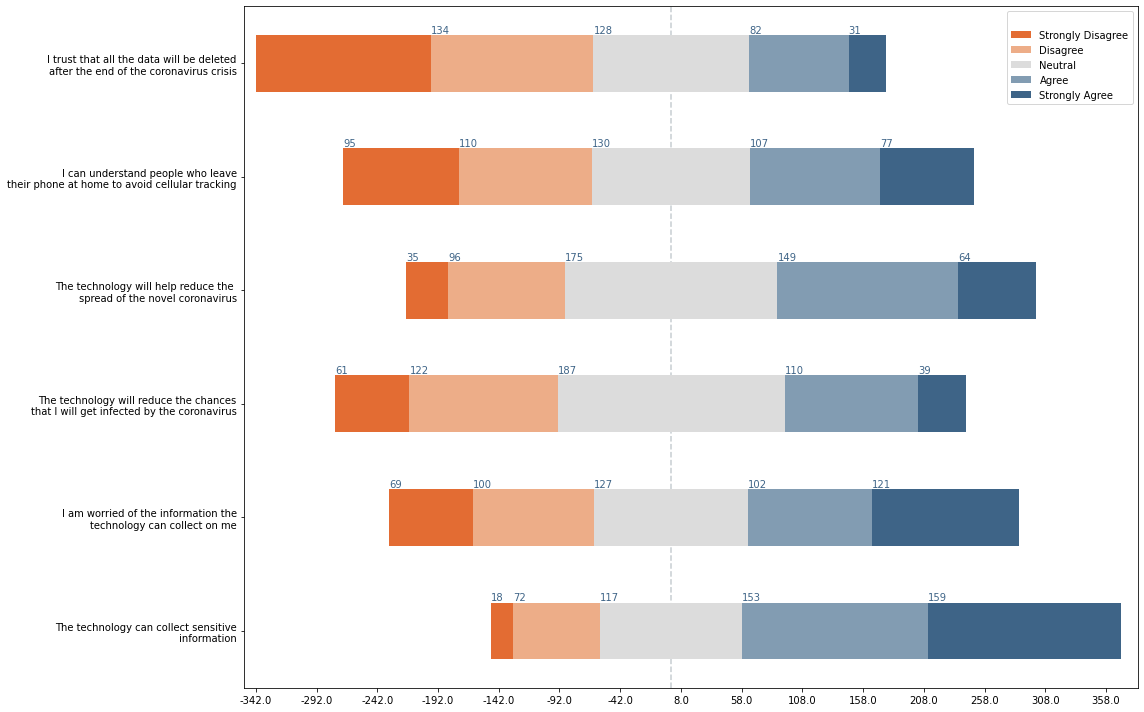

In [8]:
cols=['cellular_can_collect', 'cellular_privacy_concern', 
      'cellular_reduce_my_risk', 'cellular_help_prevent', 'cellular_accept_leave_phone_home', 'cellular_trust_delete',] 

small=sur[cols]
df1 = small.apply(pd.Series.value_counts)

likert_colors = ['firebrick','lightcoral','ivory','cornflowerblue', 'darkblue']
pivot_df = df1.transpose() 
pivot_df.rename(index={'cellular_trust_delete':'I trust that all the data will be deleted\nafter the end of the coronavirus crisis'},inplace=True)
pivot_df.rename(index={'cellular_accept_leave_phone_home':'I can understand people who leave\ntheir phone at home to avoid cellular tracking'},inplace=True)
pivot_df.rename(index={'cellular_help_prevent':'The technology will help reduce the \nspread of the novel coronavirus'},inplace=True)
pivot_df.rename(index={'cellular_reduce_my_risk':'The technology will reduce the chances\nthat I will get infected by the coronavirus'},inplace=True)
pivot_df.rename(index={'cellular_privacy_concern':'I am worried of the information the\ntechnology can collect on me'},inplace=True)
pivot_df.rename(index={'cellular_can_collect':'The technology can collect sensitive\ninformation'},inplace=True)


pivot_df.columns = ['Strongly Disagree','Disagree','Neutral',
                     'Agree','Strongly Agree']
create_stacked_bar(pivot_df, 1.4, savefile=True)

## Twitter publication

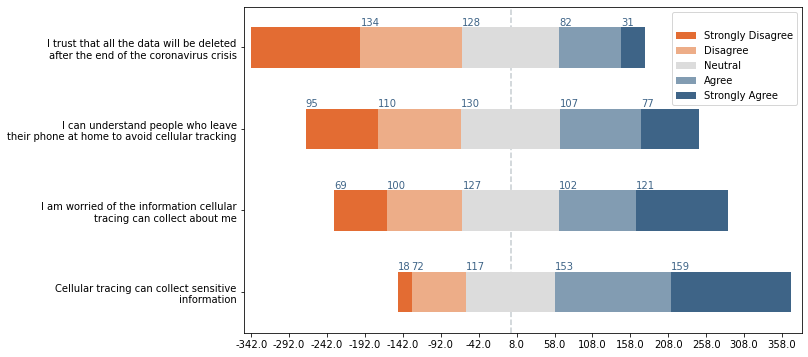

In [9]:
cols=['cellular_can_collect', 'cellular_privacy_concern', 
     'cellular_accept_leave_phone_home', 'cellular_trust_delete',] 

small=sur[cols]
df1 = small.apply(pd.Series.value_counts)

likert_colors = ['firebrick','lightcoral','ivory','cornflowerblue', 'darkblue']
pivot_df = df1.transpose() 
pivot_df.rename(index={'cellular_trust_delete':'I trust that all the data will be deleted\nafter the end of the coronavirus crisis'},inplace=True)
pivot_df.rename(index={'cellular_accept_leave_phone_home':'I can understand people who leave\ntheir phone at home to avoid cellular tracking'},inplace=True)
pivot_df.rename(index={'cellular_privacy_concern':'I am worried of the information cellular\ntracing can collect about me'},inplace=True)
pivot_df.rename(index={'cellular_can_collect':'Cellular tracing can collect sensitive\ninformation'},inplace=True)

pivot_df.columns = ['Strongly Disagree','Disagree','Neutral',
                     'Agree','Strongly Agree']
create_stacked_bar(pivot_df, 1.4, figsize=(10,6))

# Visualizing binary variables

## Binary variables
- 32 work in healthcare 
- About 110 of the 520 are in special risk
- About 147 know a person that was tested positive for Covid-19

<ipython-input-10-f7039aa59b38>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "landscape" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('output.png', format='png', landscape='landscape')


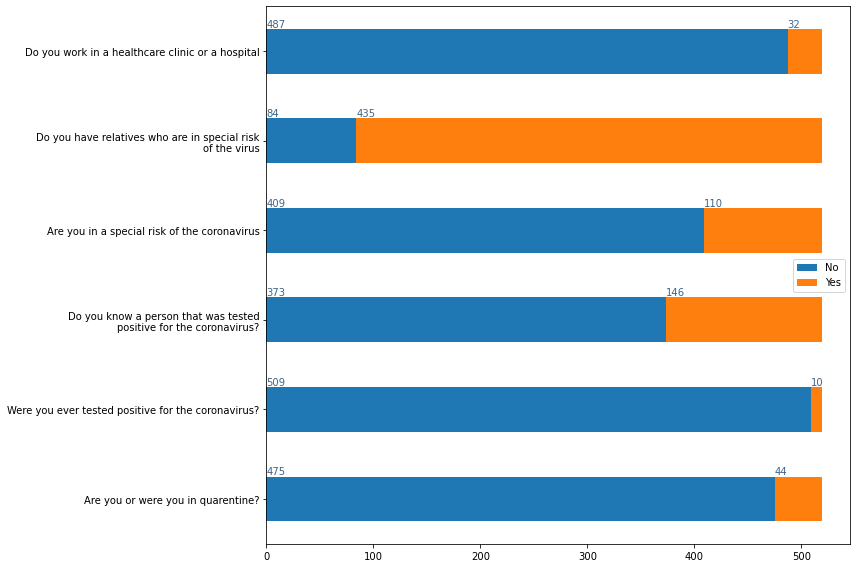

In [10]:
cols=['was_in_quarentine', 'corona_positive',  'corona_know_positive', 'special_risk', 'corona_family_risk', 
      'work_in_healthcare'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
pivot_df = df1.transpose() 

pivot_df.rename(index={'work_in_healthcare':'Do you work in a healthcare clinic or a hospital'},inplace=True)
pivot_df.rename(index={'special_risk':'Are you in a special risk of the coronavirus'},inplace=True)
pivot_df.rename(index={'corona_family_risk':'Do you have relatives who are in special risk\nof the virus'},inplace=True)
pivot_df.rename(index={'corona_know_positive':'Do you know a person that was tested\npositive for the coronavirus?'},inplace=True)
pivot_df.rename(index={'corona_positive':'Were you ever tested positive for the coronavirus?'},inplace=True)
pivot_df.rename(index={'was_in_quarentine':'Are you or were you in quarentine?'},inplace=True)


ax = pivot_df.plot.barh(stacked=True, figsize=(12,8))

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), horizontalalignment='left', verticalalignment='bottom', fontfamily='sans-serif', fontsize=10, color='#3e6487')

plt.gcf().tight_layout()
plt.savefig('output.png', format='png', landscape='landscape')

### Gender

,female,male,other
gender,276,239,4


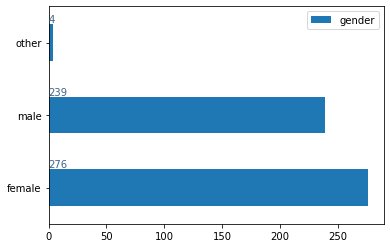

In [11]:
cols=['gender'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 
pivot_df
ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')

pivot_df

### Age

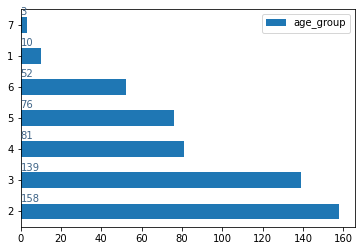

In [12]:
cols=['age_group'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 
pivot_df
ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')


In [13]:
sur.age.describe()

count    519.000000
mean      38.992871
std       13.805940
min       19.000000
25%       28.000000
50%       36.000000
75%       50.000000
max       70.000000
Name: age, dtype: float64

### Religious Identification

          Jewish  Muslim  Druze  Christian
religion     426      55     22         16


,Jewish,Muslim,Druze,Christian
religion,426,55,22,16


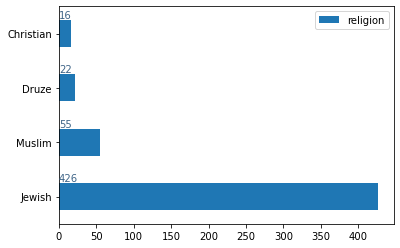

In [14]:
cols=['religion'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 
print(pivot_df)

ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')

pivot_df 

### Religious Level

                 Secular  Traditional  Other  Religious  Orthodox
religion_degree      190          139     93         57        40


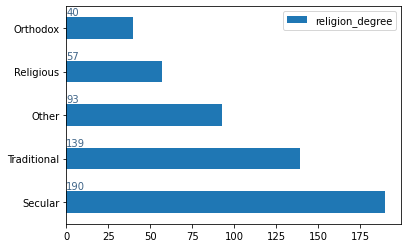

In [15]:
cols=['religion_degree'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 
print(pivot_df)

ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')


### Education

,Bachelor,Non Academic,Highschool,Graduate,Elementary
education,184,139,112,81,3


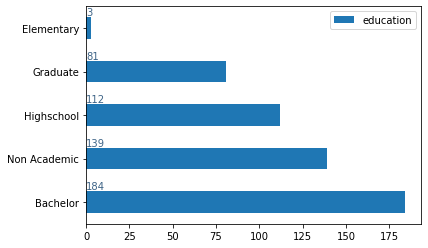

In [16]:
cols=['education'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 
ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')

pivot_df

### Socio-Economic

,Below Average,Strongly Below Average,Average,Above Average,Strongly Above Average
socio_economy,165,141,138,61,14


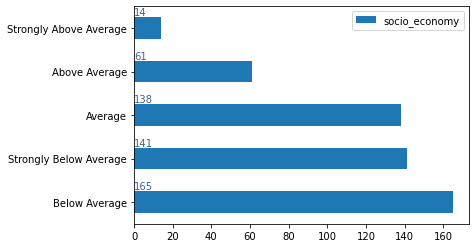

In [17]:
cols=['socio_economy'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 

ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')

pivot_df

### Computer Literacy 

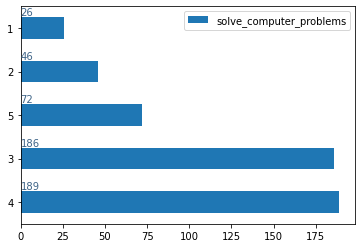

In [18]:
cols=['solve_computer_problems'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1
pivot_df = df1.transpose() 
pivot_df
ax = df1.plot.barh()

for lbl in ax.patches:
    ax.annotate(int(lbl.get_width()), (lbl.get_x(), lbl.get_y()+.5), verticalalignment='bottom', fontsize=10, color='#3e6487')


<AxesSubplot:>

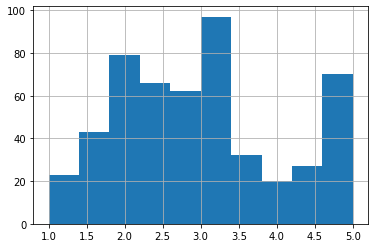

In [19]:
sur['tech'].hist()



# Analyzing Installations

Resources: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

## Creating Dummy Variables

In [21]:
sur_no_removed = sur.copy()

cat_vars=['gender','language', 'special_risk', 'work_in_healthcare', 'corona_family_risk', 'was_in_quarentine', 'corona_know_positive', 
          'corona_positive', 'age_group', 'education', 'religion', 'religion_degree', 'socio_economy']
for var in cat_vars:
    dummy = 'var'+'_'+var
    dummy = pd.get_dummies(sur[var], prefix=var)
    sur_no_removed = sur_no_removed.merge(dummy, left_index=True, right_index=True)

#sur_no_removed.info(verbose=True)



In [22]:
# Adding intercept 
sur_no_removed['intercept'] = 1.0

#Filtering uninstallations 
#sur_no_removed['hamagen_install_numbers'] = sur_no_removed['hamagen_install_numbers'].map({1 : 1, 0 : 0, 2 : 0})
sur_no_removed = sur_no_removed[sur_no_removed['hamagen_install_numbers'] < 2]
sur_no_removed['hamagen_install_numbers'].value_counts()
pd.set_option('display.max_columns', 100)


In [26]:
sur.head()

,Time Started,Date Submitted,Status,age,corona_threat_population,corona_threat_me,corona_worry_me,corona_worry_others,trust_leaders,follow_instructions,was_in_quarentine,corona_financial_hurt,corona_positive,corona_know_positive,corona_family_risk,special_risk,work_in_healthcare,hamagen_install,hamagen_recommend,hamagen_help_no_infect,hamagen_reduce_my_risk,hamagen_privacy_concern,hamagen_can_collect_sensitive,hamagen_wrong_location,hamagen_errors,hamagen_battery,hamagen_public_areas,cellular_trust_delete,cellular_accept_leave_phone_home,cellular_help_prevent,cellular_reduce_my_risk,cellular_privacy_concern,cellular_can_collect,solve_computer_problems,know_pdf,know_spyware,know_wiki,know_cache,know_phishing,gender,education,socio_economy,religion,religion_degree,language,hamagen_install_numbers,installed,gender_ord,socio_economy_level,education_level,religion_level,age_group,hamagen_can_collect,tech,language_level,religion_degree_level,gender_n,gender_cat,education_cat,age_group_n,religion_cat,cellular_trust,hamagen_privacy,cellular_utility,cellular_privacy,hamagen_limited_utility,cellular_attitude,hamagen_attitude,covid_concern,compliance,covid_trust
Response ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
379,05/05/2020 16:23,05/05/2020 16:26,Complete,21.0,3,2,4,4,3,5,No,4,No,No,Yes,No,No,No,2,3,2,4,3,NaN,NaN,NaN,2,3,4,3,2,4,3,5,5,4,5,5,5,male,Highschool,Below Average,Jewish,Secular,hebrew,0,0,1,1,2,1,2,3,4.8,1,1.0,1,1,2,2,1,-1,3.5,2.5,3.5,2.5,2.666667,2.0,3.000000,3.25,4.0
61,04/05/2020 19:23,04/05/2020 19:29,Complete,34.0,4,3,5,5,4,5,No,2,No,No,Yes,No,No,No,2,4,5,4,4,NaN,NaN,NaN,4,3,4,4,4,4,4,3,3,1,1,1,1,male,Highschool,Strongly Below Average,Muslim,Other,arabic,0,0,1,0,2,2,3,4,1.4,2,0.0,1,1,2,3,2,-1,4.0,4.0,4.0,4.5,3.666667,3.0,4.000000,4.25,4.5
280,05/05/2020 15:22,05/05/2020 15:24,Complete,21.0,2,3,4,2,3,3,No,3,No,No,No,No,No,Yes,3,3,3,3,3,3.0,3.0,3.0,3,3,3,3,3,3,3,3,3,3,3,3,3,male,Bachelor,Below Average,Druze,Other,arabic,1,1,1,1,4,3,2,3,3.0,2,0.0,1,1,4,2,3,0,3.0,3.0,3.0,3.0,3.000000,3.0,3.000000,2.75,3.0
288,05/05/2020 15:24,05/05/2020 15:33,Complete,65.0,2,3,1,1,4,5,No,3,No,No,No,No,No,No,2,4,4,3,4,NaN,NaN,NaN,1,3,3,4,4,1,4,3,4,1,1,3,1,female,Highschool,Average,Jewish,Traditional,hebrew,0,0,0,3,2,1,6,4,2.0,1,2.0,0,0,2,6,1,2,3.5,4.0,2.5,4.0,3.666667,1.5,2.000000,1.75,4.5
96,04/05/2020 23:27,04/05/2020 23:30,Complete,37.0,2,2,3,4,2,3,No,3,No,No,Yes,No,No,No,1,3,2,5,5,NaN,NaN,NaN,2,1,4,3,3,5,5,3,4,3,2,1,4,male,Bachelor,Average,Muslim,Other,arabic,0,0,1,3,4,2,3,5,2.8,2,0.0,1,1,4,3,2,-4,5.0,3.0,5.0,2.5,2.333333,1.5,2.333333,2.75,2.5


In [30]:
cols=['intercept', 'corona_family_risk_No', 'hamagen_attitude', 'covid_concern',  'trust_leaders', 'follow_instructions',
      'hamagen_limited_utility', 'hamagen_privacy', 'cellular_utility', 'tech'] 



X=sur_no_removed[cols]
y=sur_no_removed['hamagen_install_numbers']

## Feature Selection

Taken from: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

### Embedded Method with Lasso regularization

Best alpha using built-in LassoCV: 0.017432
Best score using built-in LassoCV: 0.289001
Lasso picked 4 variables and eliminated the other 6 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

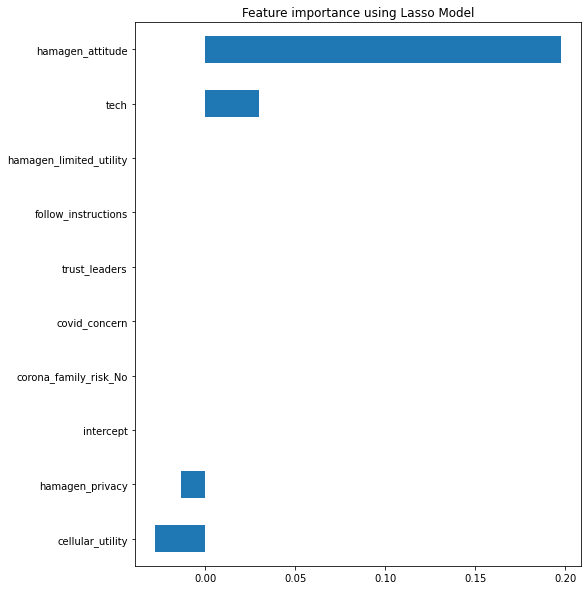

In [31]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

### Recursive Feature Elimination


In [33]:
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

model = LogisticRegression()
number_of_features = 13
#Initializing RFE model
rfe = RFE(model, number_of_features)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]
Index(['intercept', 'corona_family_risk_No', 'hamagen_attitude',
       'covid_concern', 'trust_leaders', 'follow_instructions',
       'hamagen_limited_utility', 'hamagen_privacy', 'cellular_utility',
       'tech'],
      dtype='object')


In [34]:
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))


Optimum number of features: 1
Score with 1 features: 0.790210


In [35]:
#sur_no_removed[['hamagen_install_numbers']].value_counts()
#sur_no_removed.groupby("hamagen_install_numbers")[['hamagen_install_numbers','hamagen_utility','cellular_can_collect']].mean()

## Analyzing demographics and HaMagen installations

### Installation by gender
- The proportion of installations for men is higher

In [36]:
pd.crosstab(sur.gender,sur.hamagen_install).apply(lambda r: r/r.sum(), axis=1)


hamagen_install,No,Removed,Yes
gender,,,
female,0.644928,0.079710,0.275362
male,0.531381,0.096234,0.372385
other,0.750000,0.000000,0.250000


### Installation by age group
- older adults install in about 80% more than younger adults

In [37]:
pd.crosstab(sur.age_group,sur.hamagen_install).apply(lambda r: r/r.sum(), axis=1)


hamagen_install,No,Removed,Yes
age_group,,,
1,0.600000,0.100000,0.300000
2,0.639241,0.094937,0.265823
3,0.611511,0.079137,0.309353
4,0.555556,0.086420,0.358025
5,0.592105,0.078947,0.328947
6,0.500000,0.096154,0.403846
7,0.000000,0.000000,1.000000


### Installation by Religion
- Seems that proportions of installations are similar between religions

In [38]:
pd.crosstab(sur.religion,sur.hamagen_install).apply(lambda r: r/r.sum(), axis=1)


hamagen_install,No,Removed,Yes
religion,,,
Christian,0.562500,0.062500,0.375000
Druze,0.590909,0.136364,0.272727
Jewish,0.584507,0.093897,0.321596
Muslim,0.672727,0.018182,0.309091


### Differences in installation according to religion degree
- Secular and traditional particpnats installed it more

In [39]:
pd.crosstab(sur.religion_degree,sur.hamagen_install).apply(lambda r: r/r.sum(), axis=1)


hamagen_install,No,Removed,Yes
religion_degree,,,
Orthodox,0.650000,0.075000,0.275000
Other,0.634409,0.053763,0.311828
Religious,0.666667,0.070175,0.263158
Secular,0.557895,0.105263,0.336842
Traditional,0.568345,0.093525,0.338129


In [40]:
sur.religion_degree.value_counts()

Secular        190
Traditional    139
Other           93
Religious       57
Orthodox        40
Name: religion_degree, dtype: int64

### Differences of installation according to education
- Graduates install the app about 30-40% more than others
- Number of elemntary is very small - 3

In [41]:
pd.crosstab(sur.education,sur.hamagen_install).apply(lambda r: r/r.sum(), axis=1)


hamagen_install,No,Removed,Yes
education,,,
Bachelor,0.586957,0.076087,0.336957
Elementary,0.666667,0.000000,0.333333
Graduate,0.493827,0.086420,0.419753
Highschool,0.651786,0.053571,0.294643
Non Academic,0.611511,0.129496,0.258993


In [42]:
pd.crosstab(sur.education,sur.hamagen_install).apply(lambda r: r/r.sum(), axis=1)


hamagen_install,No,Removed,Yes
education,,,
Bachelor,0.586957,0.076087,0.336957
Elementary,0.666667,0.000000,0.333333
Graduate,0.493827,0.086420,0.419753
Highschool,0.651786,0.053571,0.294643
Non Academic,0.611511,0.129496,0.258993


In [43]:
sur.education.value_counts()

Bachelor        184
Non Academic    139
Highschool      112
Graduate         81
Elementary        3
Name: education, dtype: int64

## Gender differences in cellular_accept_leave_phone_home

In [44]:
rp.summary_cont(sur['cellular_accept_leave_phone_home'].groupby(sur['gender']))

,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
female,276,2.8442,1.2853,0.0774,2.6919,2.9965
male,239,3.0084,1.3597,0.0879,2.8351,3.1816
other,4,3.5000,1.0000,0.5000,1.9088,5.0912


In [45]:
rp.summary_cont(sur['follow_instructions'].groupby(sur['corona_family_risk']))


,N,Mean,SD,SE,95% Conf.,Interval
corona_family_risk,,,,,,
No,84,3.9167,1.0321,0.1126,3.6927,4.1406
Yes,435,4.2368,0.7779,0.0373,4.1635,4.3101


# Comparing HaMagen and Cellular Tracking

Conclusions:
- We don't see significant differences in the approach 

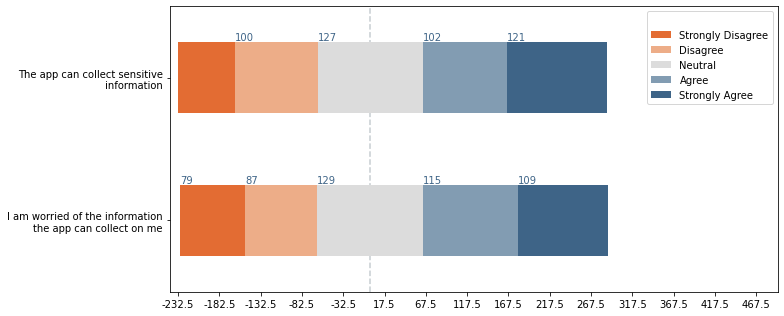

,Strongly Disagree,Disagree,Neutral,Agree,Strongly Agree
I am worried of the information\nthe app can collect on me,79,87,129,115,109
The app can collect sensitive\ninformation,69,100,127,102,121


In [46]:
cols=['hamagen_privacy_concern', 'cellular_privacy_concern'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1.head()
likert_colors = ['firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
pivot_df = df1.transpose() 

pivot_df.rename(index={'hamagen_privacy_concern':'I am worried of the information\nthe app can collect on me'},inplace=True)
pivot_df.rename(index={'cellular_privacy_concern':'The app can collect sensitive\ninformation'},inplace=True)

pivot_df.columns = ['Strongly Disagree','Disagree','Neutral','Agree','Strongly Agree']
create_stacked_bar(pivot_df, 1.4, figsize=(11,4.5), savefile=True)
pivot_df


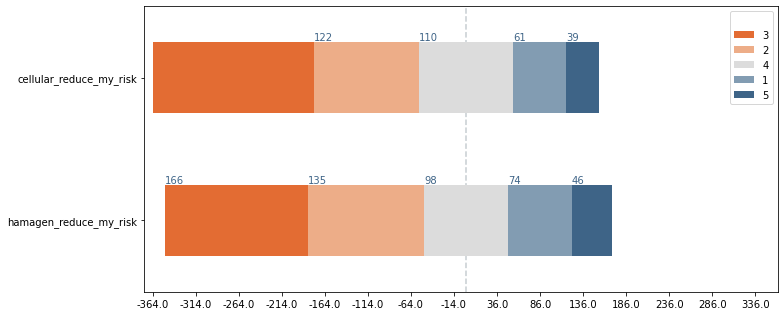

,3,2,4,1,5
hamagen_reduce_my_risk,166,135,98,74,46
cellular_reduce_my_risk,187,122,110,61,39


In [47]:
cols=['hamagen_reduce_my_risk', 'cellular_reduce_my_risk'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1.head()
likert_colors = ['firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
pivot_df = df1.transpose() 

pivot_df.rename(index={'hamagen_reduce_my_risk':'hamagen_reduce_my_risk'},inplace=True)
pivot_df.rename(index={'cellular_reduce_my_risk':'cellular_reduce_my_risk'},inplace=True)

#pivot_df.columns = ['Strongly Disagree','Disagree','Neutral','Agree','Strongly Agree']
create_stacked_bar(pivot_df, 1.4, figsize=(11,4.5), savefile=True)
pivot_df

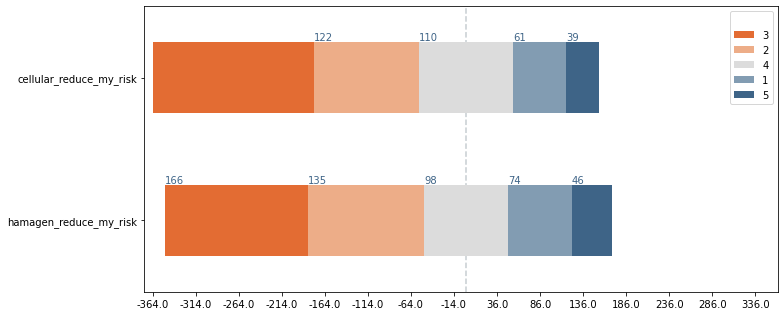

,3,2,4,1,5
hamagen_reduce_my_risk,166,135,98,74,46
cellular_reduce_my_risk,187,122,110,61,39


In [48]:
cols=['hamagen_reduce_my_risk', 'cellular_reduce_my_risk'] 
small=sur[cols]
df1 = small.apply(pd.Series.value_counts)
df1.head()
likert_colors = ['firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
pivot_df = df1.transpose() 

pivot_df.rename(index={'hamagen_reduce_my_risk':'hamagen_reduce_my_risk'},inplace=True)
pivot_df.rename(index={'cellular_reduce_my_risk':'cellular_reduce_my_risk'},inplace=True)

#pivot_df.columns = ['Strongly Disagree','Disagree','Neutral','Agree','Strongly Agree']
create_stacked_bar(pivot_df, 1.4, figsize=(11,4.5), savefile=True)
pivot_df

<AxesSubplot:xlabel='hamagen_install'>

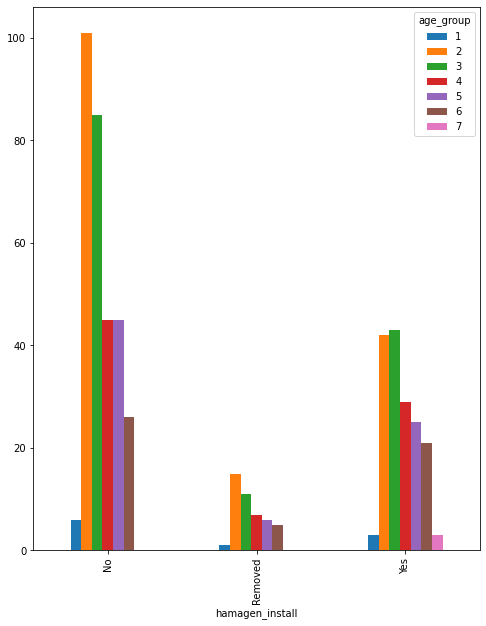

In [49]:
pd.crosstab(sur.hamagen_install,sur.age_group).plot(kind='bar')


In [50]:
sur.cellular_accept_leave_phone_home.corr(sur.cellular_trust_delete)

-0.216254002775652

Ttest_relResult(statistic=-1.8204559911317484, pvalue=0.06926646431096624)

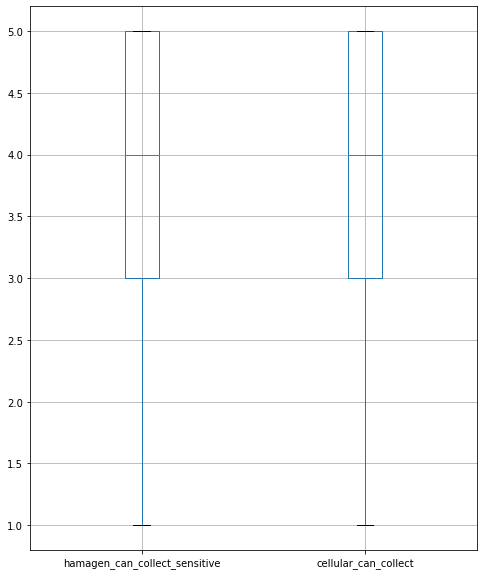

In [51]:
sur.boxplot(column=['hamagen_can_collect_sensitive', 'cellular_can_collect'])
stats.ttest_rel(sur['hamagen_can_collect_sensitive'], sur['cellular_can_collect'])
#stats.wilcoxon(sur['hamagen_help_prevent'], sur['cellular_help_prevent'])


Ttest_relResult(statistic=-0.7536231544523575, pvalue=0.4514179413395366)

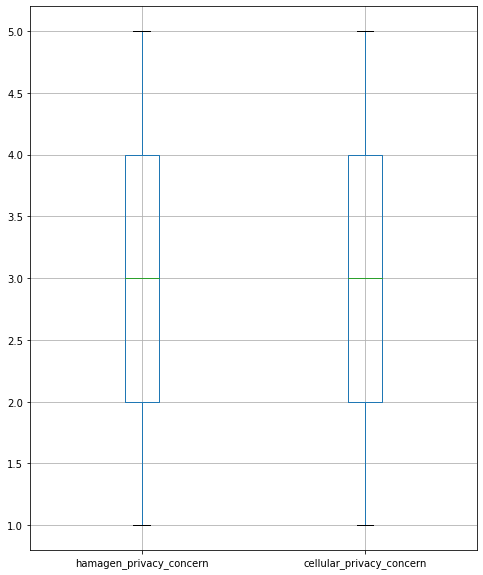

In [52]:
sur.boxplot(column=['hamagen_privacy_concern', 'cellular_privacy_concern'])
stats.ttest_rel(sur['hamagen_privacy_concern'], sur['cellular_privacy_concern'])
#stats.wilcoxon(sur['hamagen_help_prevent'], sur['cellular_help_prevent'])

Ttest_relResult(statistic=-1.7654944583904413, pvalue=0.07806979910727373)

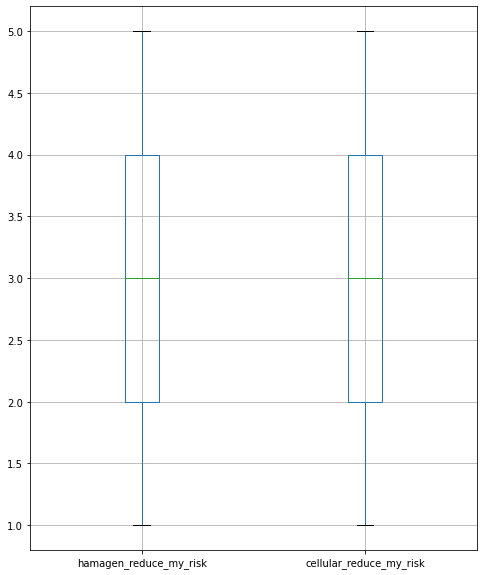

In [53]:
sur.boxplot(column=['hamagen_reduce_my_risk', 'cellular_reduce_my_risk'])
stats.ttest_rel(sur['hamagen_reduce_my_risk'], sur['cellular_reduce_my_risk'])
#stats.wilcoxon(sur['hamagen_help_prevent'], sur['cellular_help_prevent'])

WilcoxonResult(statistic=18579.5, pvalue=0.01884950499683455)

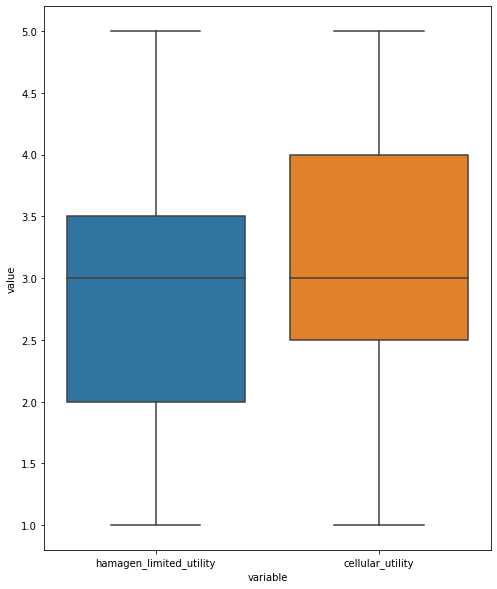

In [54]:
df = pd.DataFrame(data = sur, columns = ['hamagen_limited_utility','cellular_utility'])

sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.savefig('hamagen_cellular_utility.png', format='png', landscape='landscape', figsize=(6,6))
stats.ttest_rel(sur['hamagen_limited_utility'], sur['cellular_utility'])
stats.wilcoxon(sur['hamagen_limited_utility'], sur['cellular_utility'])

<AxesSubplot:xlabel='variable', ylabel='value'>

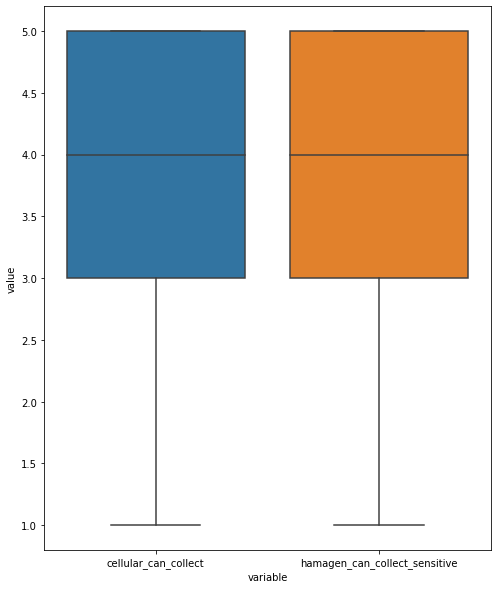

In [55]:
df = pd.DataFrame(data = sur, columns = ['cellular_can_collect','hamagen_can_collect_sensitive'])

sns.boxplot(x="variable", y="value", data=pd.melt(df))
#plt.savefig('hamagen_cellular_sensitive.png', format='png')
#stats.wilcoxon(sur['cellular_can_collect'], sur['hamagen_can_collect_sensitive'])

# Modeling Cellular Tracing 

Modeling the factors related to the question about cellular tracing: "The technology will help reduce the spread of the novel coronavirus". Answering positevely to this question is correlated with:
- corona_family_risk
- cellular_trust_delete
- trust_leaders
- cellular_reduce_my_risk

In [56]:
from statsmodels.formula.api import ols

sur['cellular_utility'] = (sur.cellular_help_prevent + sur.cellular_reduce_my_risk) / 2
sur['corona_threat'] = (sur.corona_threat_population + sur.corona_threat_population) / 2
sur['corona_worry'] = (sur.corona_worry_me + sur.corona_worry_others) / 2
sur['cellular_privacy'] = (sur.cellular_privacy_concern + sur.cellular_can_collect + (5-sur.cellular_trust_delete)) / 3

fit = ols('cellular_utility ~ cellular_trust_delete + corona_threat + trust_leaders + solve_computer_problems +  cellular_privacy_concern + cellular_can_collect + trust_leaders + corona_threat + corona_family_risk + special_risk + work_in_healthcare + tech + age + gender + language + religion_degree', data=sur).fit() 

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       cellular_utility   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     10.82
Date:                Tue, 05 Oct 2021   Prob (F-statistic):           3.03e-27
Time:                        17:18:42   Log-Likelihood:                -652.26
No. Observations:                 519   AIC:                             1345.
Df Residuals:                     499   BIC:                             1430.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.5137      0.493      3.072      0.002       0.546       2.482
corona_family_risk[T.Yes]          0.1762      0.107      1.652      0.099      -0.033       0.386
special_risk[T.Yes]               -0.1379      0.104     -1.329      0.184      -0.342       0.066
work_in_healthcare[T.Yes]         -0.2038      0.164     -1.240      0.216      -0.527       0.119
gender[T.male]                     0.2524      0.081      3.098      0.002       0.092       0.412
gender[T.other]                    0.0306      0.461      0.066      0.947      -0.875       0.936
language[T.hebrew]                -0.5971      0.370     -1.614      0.107      -1.324       0.130
language[T.other]                 -0.4810      0.412     -1.166      0.244      -1.291       0.329
religion_degree[T.Other]          -0.5494      0.393     -1.399      0.163      -1.321       0.222
religion_degree[T.Religious]      -0.1622      0.184     -0.882      0.378      -0.524       0.199
religion_degree[T.Secular]        -0.1608      0.157     -1.025      0.306      -0.469       0.148
religion_degree[T.Traditional]    -0.0413      0.159     -0.260      0.795      -0.354       0.271
cellular_trust_delete              0.3020      0.038      7.995      0.000       0.228       0.376
corona_threat                      0.0186      0.035      0.533      0.594      -0.050       0.087
trust_leaders                      0.1790      0.041      4.417      0.000       0.099       0.259
solve_computer_problems            0.1159      0.045      2.555      0.011       0.027       0.205
cellular_privacy_concern          -0.1144      0.039     -2.954      0.003      -0.191      -0.038
cellular_can_collect               0.1819      0.047      3.876      0.000       0.090       0.274
tech                              -0.0492      0.041     -1.201      0.230      -0.130       0.031
age                                0.0011      0.003      0.362      0.717      -0.005       0.007
==============================================================================
Omnibus:                        0.119   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.942   Jarque-Bera (JB):                0.096
Skew:                           0.033   Prob(JB):                        0.953
Kurtosis:                       2.997   Cond. No.                         861.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Modeling Recommending HaMagen

We test the answers to the question: "I will recommend my friends and family to install the Hamagen app"

Factors correlated with positive answers are:
- hamagen_help_no_infect
- hamagen_reduce_my_risk
- corona_worry_me

And negatively correlated with:
- hamagen_privacy_concern

In [57]:

sur['hamagen_approach'] = (sur.hamagen_recommend + sur.hamagen_help_no_infect + sur.hamagen_reduce_my_risk) / 3
sur['corona_threat'] = (sur.corona_threat_population + sur.corona_threat_population) / 2
sur['corona_worry'] = (sur.corona_worry_me + sur.corona_worry_others) / 2
sur['hamagen_privacy'] = (sur.hamagen_privacy_concern + sur.hamagen_can_collect_sensitive) / 2
fit = ols('hamagen_approach ~  corona_worry + hamagen_privacy_concern + hamagen_can_collect_sensitive + trust_leaders + corona_threat + corona_family_risk + special_risk + work_in_healthcare + tech + age + gender + language + religion_degree', data=sur).fit() 

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       hamagen_approach   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     8.613
Date:                Tue, 05 Oct 2021   Prob (F-statistic):           2.27e-20
Time:                        17:18:44   Log-Likelihood:                -674.45
No. Observations:                 519   AIC:                             1387.
Df Residuals:                     500   BIC:                             1468.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.4381      0.509      2.826      0.005       0.438       2.438
corona_family_risk[T.Yes]         -0.1706      0.112     -1.523      0.128      -0.391       0.050
special_risk[T.Yes]               -0.0209      0.108     -0.193      0.847      -0.234       0.192
work_in_healthcare[T.Yes]         -0.3081      0.172     -1.791      0.074      -0.646       0.030
gender[T.male]                     0.0767      0.085      0.904      0.366      -0.090       0.243
gender[T.other]                    0.0732      0.480      0.152      0.879      -0.871       1.017
language[T.hebrew]                 0.2149      0.385      0.558      0.577      -0.542       0.972
language[T.other]                  0.3441      0.431      0.799      0.425      -0.502       1.190
religion_degree[T.Other]           0.3517      0.410      0.857      0.392      -0.455       1.158
religion_degree[T.Religious]      -0.1702      0.191     -0.889      0.374      -0.546       0.206
religion_degree[T.Secular]        -0.1299      0.162     -0.801      0.424      -0.448       0.189
religion_degree[T.Traditional]     0.0211      0.164      0.128      0.898      -0.302       0.344
corona_worry                       0.1390      0.049      2.810      0.005       0.042       0.236
hamagen_privacy_concern           -0.1953      0.039     -4.990      0.000      -0.272      -0.118
hamagen_can_collect_sensitive      0.0508      0.044      1.165      0.245      -0.035       0.136
trust_leaders                      0.2869      0.040      7.237      0.000       0.209       0.365
corona_threat                      0.0407      0.047      0.870      0.385      -0.051       0.133
tech                               0.0376      0.038      0.985      0.325      -0.037       0.113
age                                0.0048      0.003      1.481      0.139      -0.002       0.011
==============================================================================
Omnibus:                        0.238   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.888   Jarque-Bera (JB):                0.299
Skew:                          -0.049   Prob(JB):                        0.861
Kurtosis:                       2.934   Cond. No.                         863.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""